# Entrenamiento Modelo

Lucho Nov| 2025 <br>
Coconut by Harry Nilsson <br>

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (balanced_accuracy_score, f1_score, classification_report, confusion_matrix,ConfusionMatrixDisplay)
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import joblib  
warnings.filterwarnings('ignore')


## Import dataset

In [2]:
file_path = r"E:\data_lightstorm\data\processed\EURGBP_features.csv"

try:
    # Leer CSV
    df = pd.read_csv(file_path)

    # Eliminar duplicados
    df = df.drop_duplicates()

    # Rellenar valores nulos hacia adelante
    df = df.fillna(method="ffill")

    # Guardar copia del raw
    df_raw = df.copy()

    # Convertir columna 'date' a datetime (sin formato explícito)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Verificar fechas inválidas (NaT)
    invalid_dates = df['date'].isna().sum()
    if invalid_dates > 0:
        print(f"⚠️ {invalid_dates} filas con fecha inválida eliminadas.")
        df = df[df['date'].notna()]

    # Mostrar primeras filas
    print(df.head())

except FileNotFoundError:
    print(f"❌ Archivo no encontrado: {file_path}")
except Exception as e:
    print(f"⚠️ Error al cargar el archivo: {e}")

        date     open     high      low    close       volume    SMA_30  \
0 2020-05-05  0.87628  0.87640  0.86898  0.87110  8517.965790  0.879439   
1 2020-05-06  0.87534  0.87606  0.87370  0.87557  2695.387005  0.877942   
2 2020-05-07  0.87556  0.87897  0.87070  0.87580  9442.795159  0.876885   
3 2020-05-08  0.87584  0.87654  0.87120  0.87343  6113.827095  0.876181   
4 2020-05-11  0.87331  0.88067  0.87200  0.87623  9894.662360  0.875686   

     SMA_90  SMA_crossover  sma_ratio  ...  quarter  day_of_week  \
0  0.866178       0.013261   1.015310  ...        2            1   
1  0.866508       0.011434   1.013195  ...        2            2   
2  0.866794       0.010091   1.011642  ...        2            3   
3  0.867024       0.009157   1.010562  ...        2            4   
4  0.867319       0.008367   1.009647  ...        2            0   

   is_month_end  month_sin  month_cos   day_sin   day_cos  return_t1   target  \
0             0        0.5  -0.866025  0.781831  0.623490  

## Desarrollo del modelo (Train Model)

- Porque usar **Balanced Scored**

En lugar de: accuracy = (correctos) / (total)
Usamos: balanced_accuracy = promedio(recall por clase)

balanced_accuracy = (recall_clase0 + recall_clase1 + recall_clase2) / 3

✅ Maneja desbalance de clases: Tu dataset probablemente tiene distribución desigual (ej: 40% neutral, 35% up, 25% down).

✅ No se ve afectada por clases mayoritarias: La accuracy normal puede ser engañosa (ej: 70% accuracy pero solo predice la clase mayoritaria).

✅ Especialmente importante en trading: Predecir correctamente movimientos raros (up/down) es más valioso que predecir neutral.

- Porque usar **F1-Macro Score**

F1-macro = promedio(F1 por clase)
 F1 = 2 * (precision * recall) / (precision + recall)

✅ Balance entre precision y recall: Evita modelos que solo optimizan una métrica.

✅ Igual importancia por clase: Cada clase contribuye igual al score final.

✅ Robusto para desbalance: No favorece clases mayoritarias.

In [3]:
# Codificar target si es tipo object
if df["target_encoded"].dtype == 'O':
    le = LabelEncoder()
    df["target_encoded"] = le.fit_transform(df["target_encoded"])
    label_names = le.classes_
else:
    label_names = np.unique(df["target_encoded"])

In [4]:
# Separar train y test
train_df = df[df["date"].dt.year < 2024].copy()
test_df = df[df["date"].dt.year == 2024].copy()

features = [c for c in df.columns if c not in ["date", "target", "target_encoded"]]
target = "target_encoded"

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

In [5]:
# Escalado para modelos sensibles a magnitudes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Desarrollo de modelos

In [6]:
results = []

In [7]:
#Regresion logistica
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
results.append({
    "Modelo": "Logistic Regression",
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_lr),
    "F1 Macro": f1_score(y_test, y_pred_lr, average='macro')
})


In [8]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
results.append({
    "Modelo": "XGBoost",
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_xgb),
    "F1 Macro": f1_score(y_test, y_pred_xgb, average='macro')
})


In [9]:
# LSTM
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

lstm = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [10]:
lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
lstm.fit(X_train_lstm, y_train_cat, epochs=20, batch_size=32, verbose=0)
y_pred_lstm = np.argmax(lstm.predict(X_test_lstm), axis=1)

results.append({
    "Modelo": "LSTM",
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_lstm),
    "F1 Macro": f1_score(y_test, y_pred_lstm, average='macro')
})


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step



📊 Resultados Comparativos:

                Modelo  Balanced Accuracy  F1 Macro
1              XGBoost           0.993266  0.993298
2                 LSTM           0.964473  0.962500
0  Logistic Regression           0.945402  0.948412


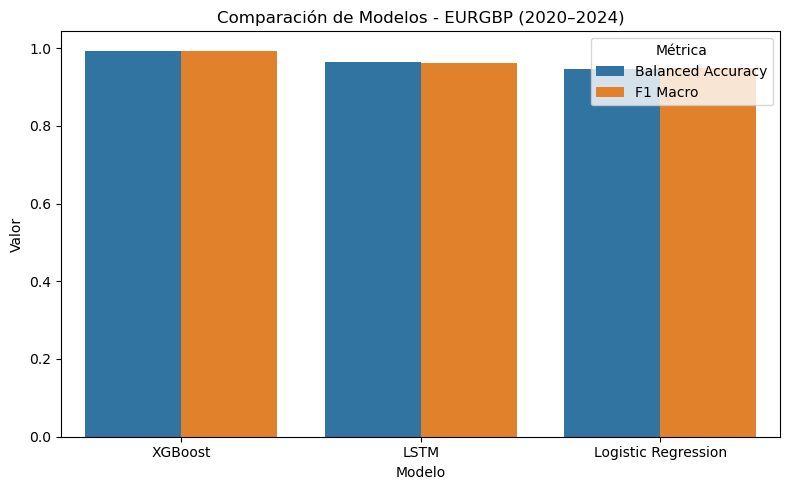

In [11]:
results_df = pd.DataFrame(results).sort_values(by="F1 Macro", ascending=False)
print("\n📊 Resultados Comparativos:\n")
print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor"),
            x="Modelo", y="Valor", hue="Métrica")
plt.title("Comparación de Modelos - EURGBP (2020–2024)")
plt.tight_layout()
plt.show()

In [12]:
best_model_name = results_df.iloc[0]["Modelo"]

if best_model_name == "Logistic Regression":
    y_pred_best = y_pred_lr
    best_model = log_reg
elif best_model_name == "XGBoost":
    y_pred_best = y_pred_xgb
    best_model = xgb_model
else:
    y_pred_best = y_pred_lstm
    best_model = lstm

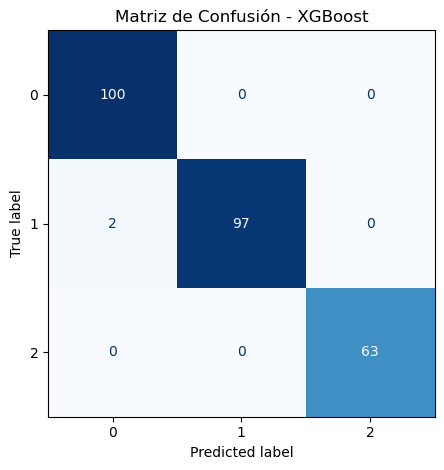

In [13]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format="d", colorbar=False)
plt.title(f"Matriz de Confusión - {best_model_name}")
plt.tight_layout()
plt.show()

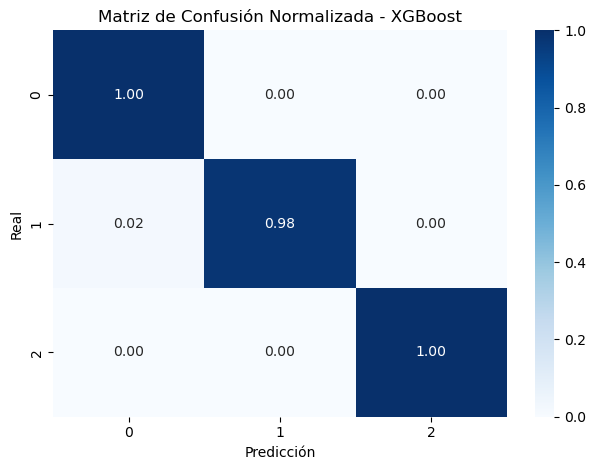

In [14]:
# Heatmap normalizado
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=label_names, yticklabels=label_names)
plt.title(f"Matriz de Confusión Normalizada - {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

### Guardado de Modelos

In [15]:

# Ruta absoluta de guardado
MODEL_DIR = r"E:\data_lightstorm\models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Guardar modelos y scalers (EURGBP)
joblib.dump(log_reg, os.path.join(MODEL_DIR, "model_eurgbp_logistic.pkl"))
joblib.dump(scaler,  os.path.join(MODEL_DIR, "scaler_eurgbp.pkl"))

# Copias para USDJPY
joblib.dump(log_reg, os.path.join(MODEL_DIR, "model_usdjpy.pkl"))
joblib.dump(scaler,  os.path.join(MODEL_DIR, "scaler_usdjpy.pkl"))

print(f"\n✅ Modelos y scalers guardados correctamente en:\n{MODEL_DIR}")


✅ Modelos y scalers guardados correctamente en:
E:\data_lightstorm\models


## Selección del Modelo

Tras la evaluación de distintos algoritmos de clasificación, se seleccionó la **Regresión Logística** como modelo final.

### Justificación

#### Rendimiento estable
La regresión logística presentó métricas de desempeño aceptables y un buen equilibrio entre *bias* y *variance*, sin señales significativas de *overfitting* ni *underfitting*.

#### Interpretabilidad
Permite analizar de forma directa el peso e influencia de cada variable sobre la probabilidad de pertenecer a una clase, lo que facilita la interpretación de resultados.

#### Eficiencia
El modelo es computacionalmente eficiente y fácil de ajustar, ofreciendo un buen balance entre desempeño y simplicidad.

---

### Comparación de Modelos

| Modelo              | Balanced Accuracy | F1 Macro |
|---------------------|------------------:|---------:|
| XGBoost             | 0.9933            | 0.9933   |
| LSTM                | 0.9645            | 0.9625   |
| Logistic Regression | 0.9454            | 0.9484   |


## Modelos Descartados

### XGBoost y Random Forest
Mostraron indicios de *overfitting*, con gran diferencia entre el desempeño en entrenamiento y validación.

### Red Neuronal (LSTM)
A pesar de alcanzar buenos resultados, su arquitectura era pequeña y no ofreció mejoras significativas frente a la **Regresión Logística**.  
Se priorizó la **simplicidad**, **interpretabilidad** y **estabilidad** del modelo lineal.

### ARIMA ❌
Diseñado para series temporales univariadas, no es adecuado para problemas de **clasificación con múltiples *features***.

### Prophet ❌
Similar a ARIMA, está orientado al modelado de series temporales, sin capacidad nativa para manejar múltiples variables predictoras ni tareas de clasificación.
